In [2]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import norm, skew
from scipy import stats
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
#njobs = 4

In [642]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [643]:
#Save the 'Id' column
trainid = df_train['Id']
testid = df_test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)


__concat two dataset__

In [644]:
print(df_train.shape)
print(df_test.shape)

(1460, 80)
(1459, 79)


In [645]:
ntrain = df_train.shape[0]
ntest = df_test.shape[0]

In [646]:
df_train_Y = np.log(df_train.SalePrice.values)

In [647]:
df_train = df_train.drop("SalePrice",axis=1)

In [648]:
df_total = pd.concat((df_train, df_test)).reset_index(drop=True)

In [649]:
df_total.shape

(2919, 79)

__Basic EDA__

In [994]:
df_total.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [710]:
df_train['SalePrice'].describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


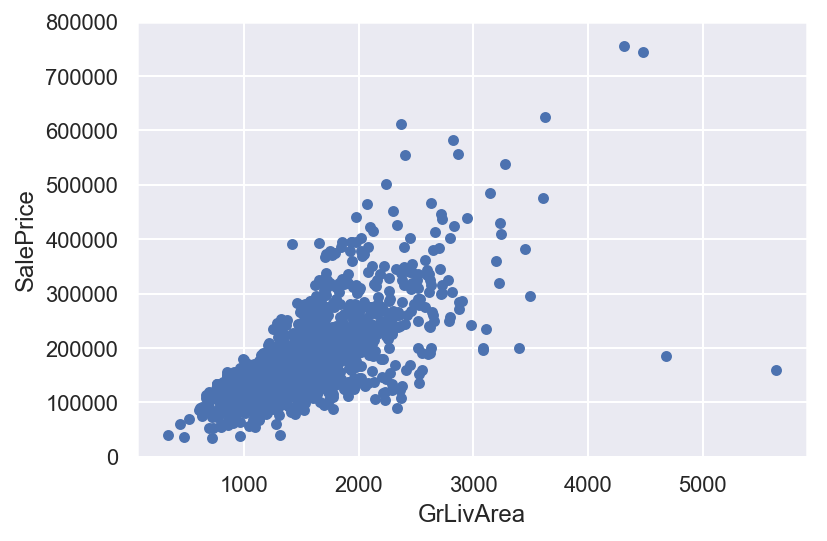

In [711]:
data = pd.concat([df_train['SalePrice'], df_train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


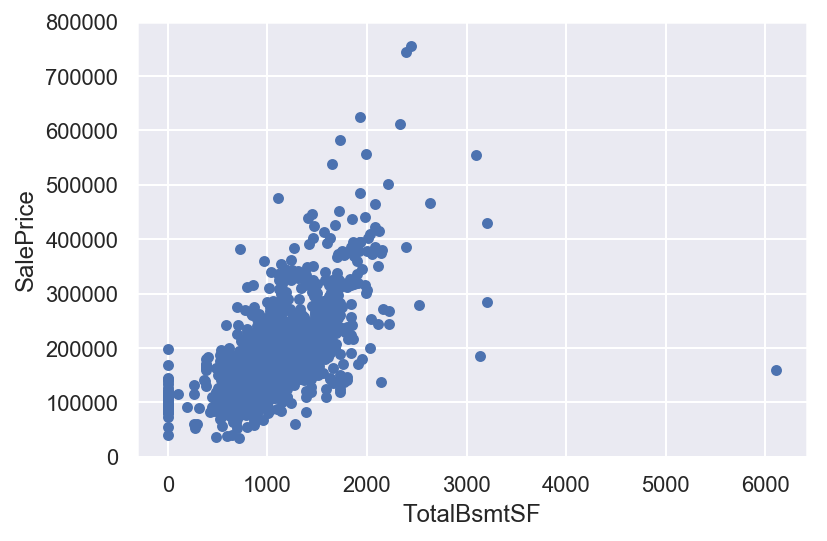

In [712]:
data = pd.concat([df_train['SalePrice'], df_train['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0,800000));

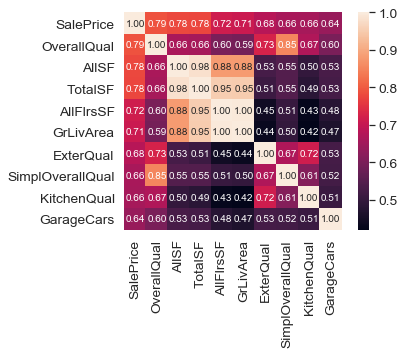

In [618]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
corrmat = df_train.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()
#time series analysis on YearBuilt 


In [621]:
df_train.corr().loc['SalePrice'].sort_values(ascending=False)

SalePrice            1.000
OverallQual          0.791
AllSF                0.779
TotalSF              0.777
AllFlrsSF            0.717
GrLivArea            0.709
ExterQual            0.683
SimplOverallQual     0.663
KitchenQual          0.660
GarageCars           0.640
TotalBath            0.632
GarageScore          0.625
GarageArea           0.623
SimplGarageScore     0.620
SimplExterQual       0.615
TotalBsmtSF          0.614
TotalGarage          0.607
1stFlrSF             0.606
BsmtQual             0.585
ExterGrade           0.576
SimplKitchenQual     0.571
FullBath             0.561
TotRmsAbvGrd         0.534
YearBuilt            0.523
FireplaceQu          0.520
FireplaceScore       0.510
YearRemodAdd         0.507
SimplBsmtQual        0.500
SimplFireplaceQu     0.494
SimplExterGrade      0.493
                     ...  
SimplGarageCond      0.237
PavedDrive           0.231
BsmtFullBath         0.227
SimplBsmtFinType1    0.217
BsmtUnfSF            0.214
BsmtCond             0.213
A

/Users/basement/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


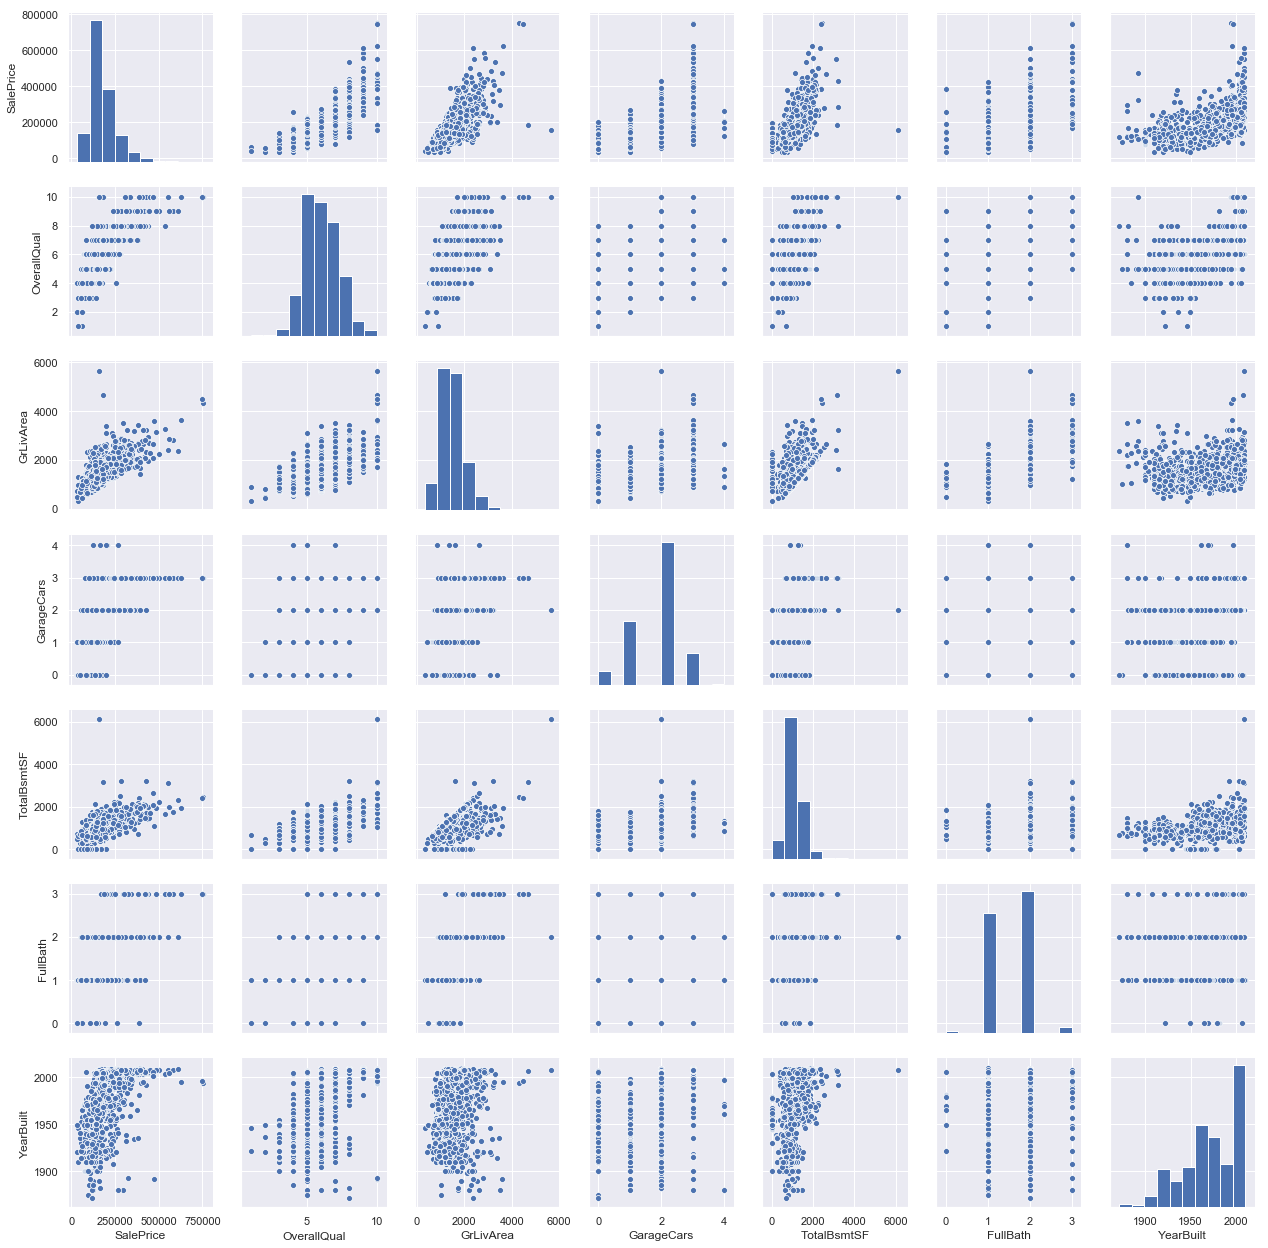

In [616]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

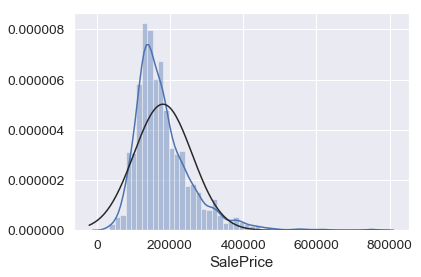

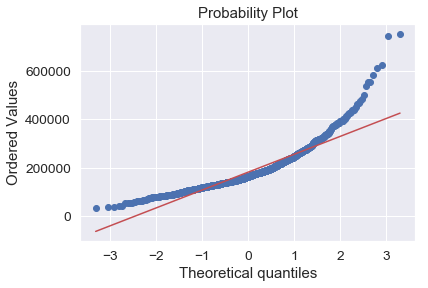

In [623]:
sns.distplot(df_train['SalePrice'] , fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

In [716]:
#applying log transformation
df_train['SalePrice'] = np.log(df_train['SalePrice'])

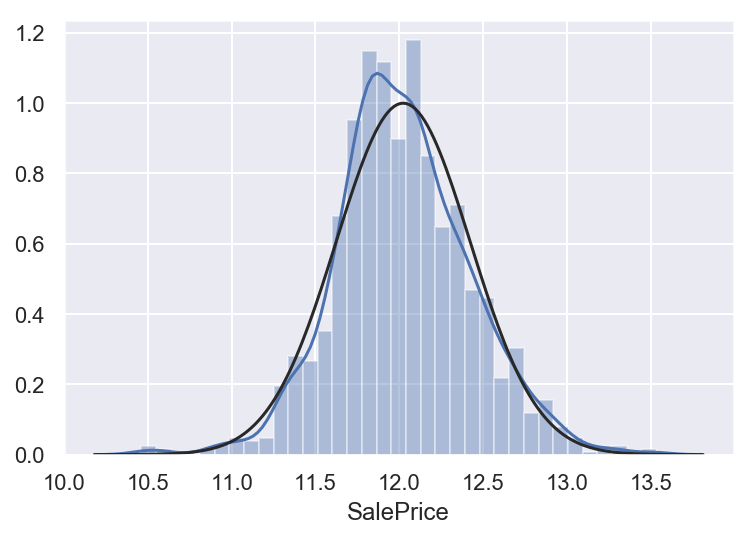

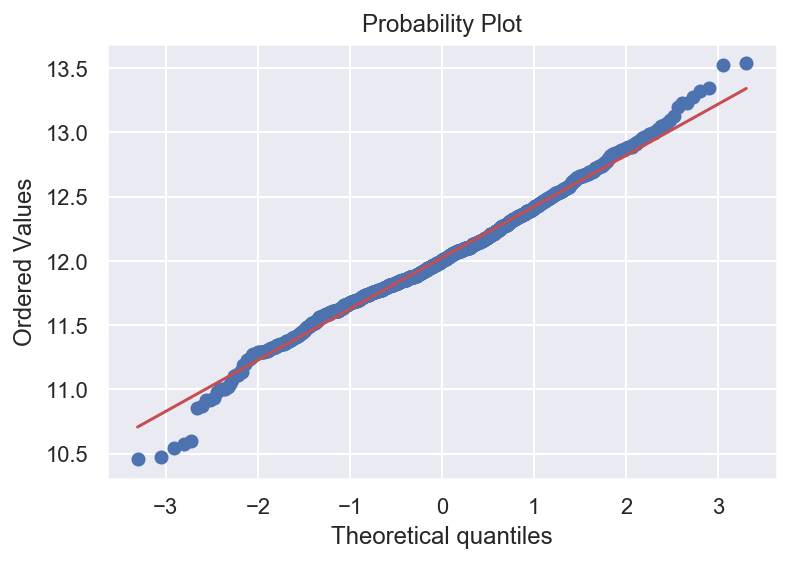

In [717]:
#transformed histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

In [718]:
#log transformation 
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

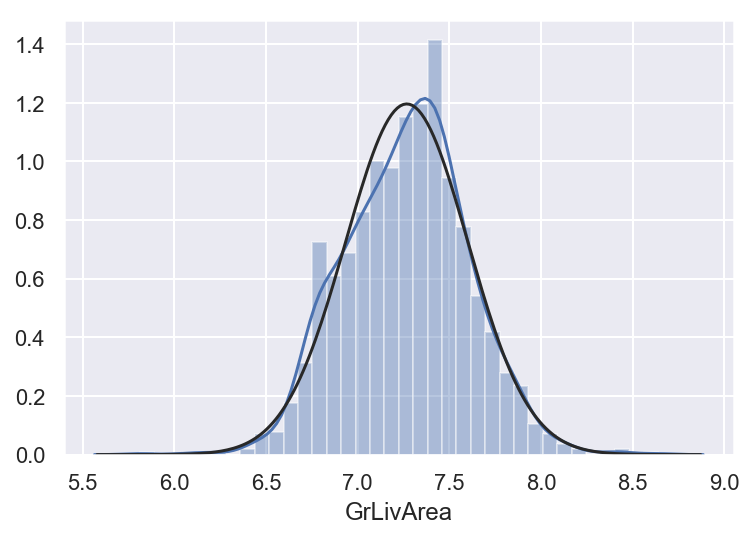

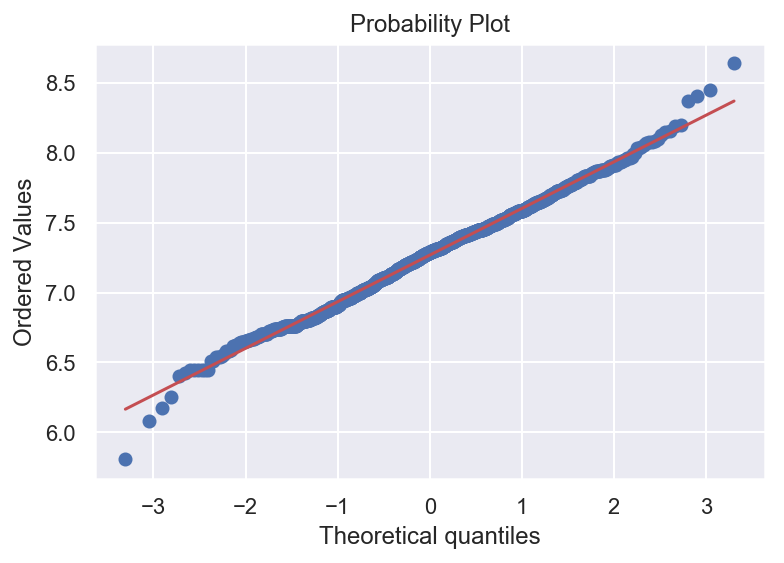

In [719]:
#transformed histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

__Missing Value Imputation__

In [759]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [584]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995
MiscFeature,1406,0.963
Alley,1369,0.938
Fence,1179,0.808
FireplaceQu,690,0.473
LotFrontage,259,0.177
GarageCond,81,0.055
GarageType,81,0.055
GarageYrBlt,81,0.055
GarageFinish,81,0.055


In [588]:
#text shows that they are No 
df_train.loc[:,"PoolQC"] = df_train.loc[:,"PoolQC"].fillna("None")
df_train.loc[:,"MiscFeature"] = df_train.loc[:,"MiscFeature"].fillna("None")
df_train.loc[:,"Alley"] = df_train.loc[:,"Alley"].fillna("None")
df_train.loc[:,"Fence"] = df_train.loc[:,"Fence"].fillna("None")
df_train.loc[:,"FireplaceQu"] = df_train.loc[:,"FireplaceQu"].fillna("None")

#filling NAs with medians
df_train["LotFrontage"] = df_train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'): #NAs means that there is no Garage
    df_train.loc[:,col] = df_train.loc[:,col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'): #putting 0s for NAs in numerical values
    df_train.loc[:,col] = df_train.loc[:,col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'): 
    #put 0 for NAs Square Footages
    df_train.loc[:,col] = df_train.loc[:,col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    #NAs means that there is no Basement
    df_train.loc[:,col] = df_train.loc[:,col].fillna('None')

df_train.loc[:,"MasVnrType"] = df_train.loc[:,"MasVnrType"].fillna("None")
df_train.loc[:,"MasVnrArea"] = df_train.loc[:,"MasVnrArea"].fillna(0)
df_train.loc[:,'MSZoning'] = df_train.loc[:,'MSZoning'].fillna(df_train['MSZoning'].mode()[0])
df_train = df_train.drop(['Utilities'], axis=1)
df_train.loc[:,"Functional"] = df_train.loc[:,"Functional"].fillna("Typ")
df_train.loc[:,'Electrical'] = df_train.loc[:,'Electrical'].fillna(df_train['Electrical'].mode()[0])
df_train.loc[:,'KitchenQual'] = df_train.loc[:,'KitchenQual'].fillna(df_train['KitchenQual'].mode()[0])
df_train.loc[:,'Exterior1st'] = df_train.loc[:,'Exterior1st'].fillna(df_train['Exterior1st'].mode()[0])
df_train.loc[:,'Exterior2nd'] = df_train.loc[:,'Exterior2nd'].fillna(df_train['Exterior2nd'].mode()[0])
df_train.loc[:,'SaleType'] = df_train.loc[:,'SaleType'].fillna(df_train['SaleType'].mode()[0])
df_train.loc[:,'MSSubClass'] = df_train.loc[:,'MSSubClass'].fillna("None")

In [590]:
df_train_na = (df_train.isnull().sum() / len(df_train)) * 100
df_train_na = df_train_na.drop(df_train_na[df_train_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :df_train_na})
print(missing_data.head())
print("")
print(missing_data['Missing Ratio'].sum())

Empty DataFrame
Columns: [Missing Ratio]
Index: []

0.0


__Feature Engineering__

In [591]:
#MSSubClass=The building class
df_train.loc[:,'MSSubClass'] = df_train.loc[:,'MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
df_train.loc[:,'OverallCond'] = df_train.loc[:,'OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
df_train.loc[:,'YrSold'] = df_train.loc[:,'YrSold'].astype(str)
df_train.loc[:,'MoSold'] = df_train.loc[:,'MoSold'].astype(str)

In [592]:
# Encode ordinal categorical features as ordered numbers when there is information in the order
df_train = df_train.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"None" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

In [594]:
# 2* Combinations of existing features
# Overall quality of the house
df_train["OverallGrade"] = df_train["OverallQual"] * df_train["OverallCond"]

# Overall garage score
df_train["GarageScore"] = df_train["GarageArea"] * df_train["GarageQual"]
# Overall quality of the garage
df_train["GarageGrade"] = df_train["GarageQual"] * df_train["GarageCond"]

#Check if this one has bigger correlation than the other two
df_train["TotalGarage"] = df_train["GarageArea"] * df_train["GarageQual"] * df_train["GarageCond"]

# Overall quality of the exterior
df_train["ExterGrade"] = df_train["ExterQual"] * df_train["ExterCond"]
# Overall kitchen score
df_train["KitchenScore"] = df_train["KitchenAbvGr"] * df_train["KitchenQual"]
# Overall fireplace score
df_train["FireplaceScore"] = df_train["Fireplaces"] * df_train["FireplaceQu"]
# Overall pool score

df_train["PoolScore"] = df_train["PoolArea"] * df_train["PoolQC"]

df_train["TotalBath"] = df_train["BsmtFullBath"] + (0.5 * df_train["BsmtHalfBath"]) + df_train["FullBath"] + (0.5 * df_train["HalfBath"])

# Total SF for house (incl. basement)
df_train["AllSF"] = df_train["GrLivArea"] + df_train["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
df_train["AllFlrsSF"] = df_train["1stFlrSF"] + df_train["2ndFlrSF"]
#Check if this one has bigger correlation than the other two
df_train["TotalSF"] = df_train["GrLivArea"] + df_train["TotalBsmtSF"] + df_train["1stFlrSF"] + df_train["2ndFlrSF"]

# Total SF for porch
df_train["AllPorchSF"] = df_train["OpenPorchSF"] + df_train["EnclosedPorch"] + df_train["3SsnPorch"] + df_train["ScreenPorch"]
# Has masonry veneer or not
df_train["HasMasVnr"] = df_train.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
df_train["HomeCompleteorNot"] = df_train.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

In [ ]:
#scatterplot
sns.set()
cols = ['SalePrice','OverallQual', 'AllSF', 'AllFlrsSF', 'TotalSF', 'GarageGrade', 'GarageScore', 'TotalGarage']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

/Users/basement/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


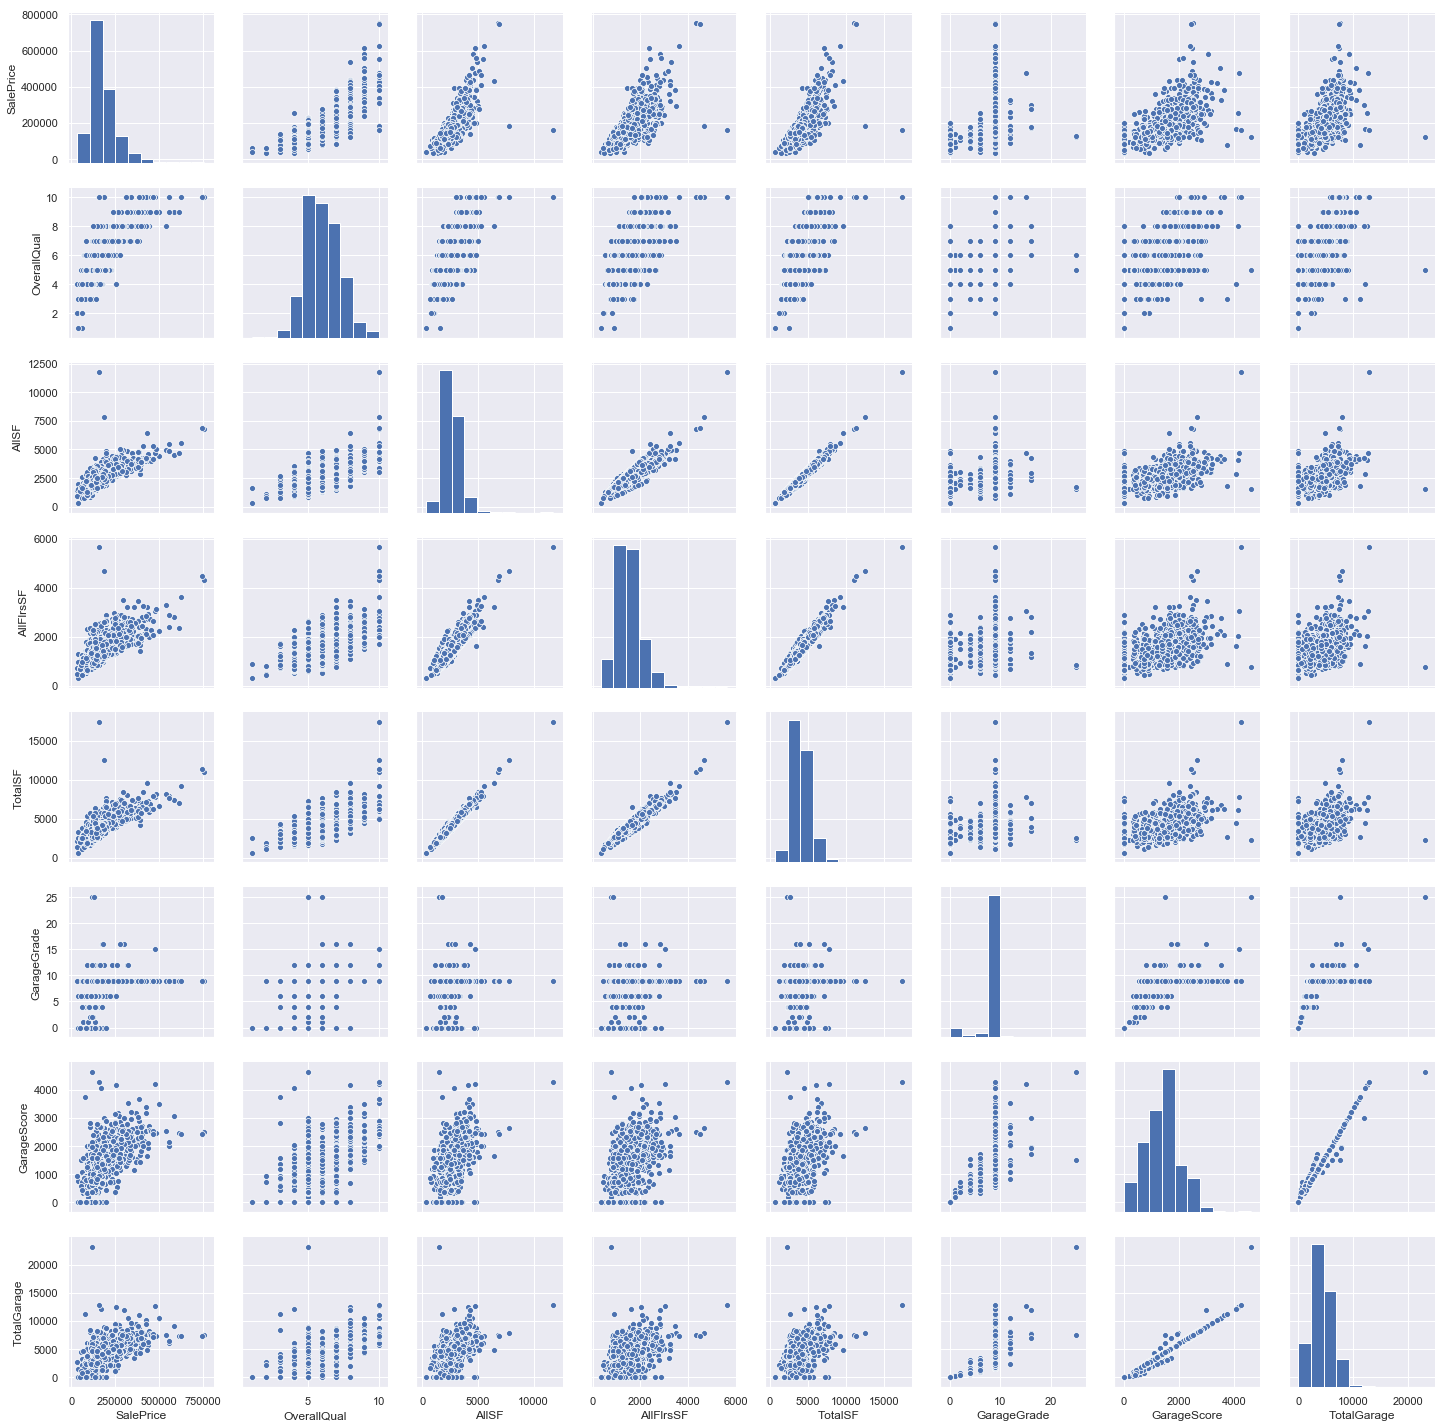

In [604]:
#scatterplot
sns.set()
cols = ['SalePrice','OverallQual', 'AllSF', 'AllFlrsSF', 'TotalSF', 'GarageGrade', 'GarageScore', 'TotalGarage']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

In [603]:
plt.savefig('polynomial_regression.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

In [911]:
# Create new features
# 3* Polynomials on the top 10 existing features
#polynomial regression -> does this when you believe the correlation is not linear
df_train["OverallQual-s2"] = df_train["OverallQual"] ** 2
df_train["OverallQual-s3"] = df_train["OverallQual"] ** 3
df_train["OverallQual-Sq"] = np.sqrt(df_train["OverallQual"])
df_train["AllSF-2"] = df_train["AllSF"] ** 2
df_train["AllSF-3"] = df_train["AllSF"] ** 3
df_train["AllSF-Sq"] = np.sqrt(df_train["AllSF"])
df_train["AllFlrsSF-2"] = df_train["AllFlrsSF"] ** 2
df_train["AllFlrsSF-3"] = df_train["AllFlrsSF"] ** 3
df_train["AllFlrsSF-Sq"] = np.sqrt(df_train["AllFlrsSF"])

df_train["TotalSF-2"] = df_train["TotalSF"] ** 2
df_train["TotalSF-3"] = df_train["TotalSF"] ** 3
df_train["TotalSF-Sq"] = np.sqrt(df_train["TotalSF"])

df_train["GrLivArea-2"] = df_train["GrLivArea"] ** 2
df_train["GrLivArea-3"] = df_train["GrLivArea"] ** 3
df_train["GrLivArea-Sq"] = np.sqrt(df_train["GrLivArea"])
# df_train["SimplOverallQual-s2"] = df_train["SimplOverallQual"] ** 2
# df_train["SimplOverallQual-s3"] = df_train["SimplOverallQual"] ** 3
# df_train["SimplOverallQual-Sq"] = np.sqrt(df_train["SimplOverallQual"])
df_train["ExterQual-2"] = df_train["ExterQual"] ** 2
df_train["ExterQual-3"] = df_train["ExterQual"] ** 3
df_train["ExterQual-Sq"] = np.sqrt(df_train["ExterQual"])
df_train["GarageCars-2"] = df_train["GarageCars"] ** 2
df_train["GarageCars-3"] = df_train["GarageCars"] ** 3
df_train["GarageCars-Sq"] = np.sqrt(df_train["GarageCars"])
df_train["TotalBath-2"] = df_train["TotalBath"] ** 2
df_train["TotalBath-3"] = df_train["TotalBath"] ** 3
df_train["TotalBath-Sq"] = np.sqrt(df_train["TotalBath"])
df_train["KitchenQual-2"] = df_train["KitchenQual"] ** 2
df_train["KitchenQual-3"] = df_train["KitchenQual"] ** 3
df_train["KitchenQual-Sq"] = np.sqrt(df_train["KitchenQual"])
df_train["GarageScore-2"] = df_train["GarageScore"] ** 2
df_train["GarageScore-3"] = df_train["GarageScore"] ** 3
df_train["GarageScore-Sq"] = np.sqrt(df_train["GarageScore"])

df_train["TotalGarage-2"] = df_train["TotalGarage"] ** 2
df_train["TotalGarage-3"] = df_train["TotalGarage"] ** 3
df_train["TotalGarage-Sq"] = np.sqrt(df_train["TotalGarage"])

__Box Cox Transformation for skewed feature__

In [912]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    df_train[feat] = boxcox1p(df_train[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 81 skewed numerical features to Box Cox transform


__Dummification__

In [913]:
categorical = df_train.select_dtypes(include = ["object"]).columns
numerical = df_train.select_dtypes(exclude = ["object"]).columns
print("Number of Categorical features: " + str(len(categorical)))
print("Number of Numerical features: " + str(len(numerical)))
df_train_categorical = df_train[categorical]
df_train_numerical = df_train[numerical]

Number of Categorical features: 34
Number of Numerical features: 118


In [914]:
df_train_categorical = pd.get_dummies(df_train_categorical)

In [915]:
train = pd.concat([df_train_numerical, df_train_categorical], axis = 1)
train.shape

(1460, 436)

In [916]:
train.columns

Index(['Id', 'LotFrontage', 'LotArea', 'Street', 'LotShape', 'LandSlope',
       'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       ...
       'SimplOverallGrade_66', 'SimplOverallGrade_666', 'SimplOverallGrade_7',
       'SimplOverallGrade_77', 'SimplOverallGrade_777', 'SimplOverallGrade_8',
       'SimplOverallGrade_88', 'SimplOverallGrade_888', 'SimplOverallGrade_99',
       'SimplOverallGrade_999'],
      dtype='object', length=436)

__Modeling__

In [917]:
from sklearn.linear_model import ElasticNet, Ridge, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [918]:
# Standardize numerical features
# stdSc = RobustScaler()
# train.loc[:, numerical] = stdSc.fit_transform(train.loc[:, numerical])

In [624]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

#Validation function
n_folds = 5

def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df_train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, df_train_Y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [625]:
ridge = make_pipeline(RobustScaler(), Ridge(alpha =0.0005, random_state=1))
score = rmse_cv(ridge)
print("\nRidge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Ridge score: 0.1467 (0.0157)



In [626]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmse_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



Lasso score: 0.1224 (0.0161)



/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [922]:
train = train.drop(["SalePrice","Id"], axis=1)

In [627]:
lasso1 = Lasso(alpha =0.0005, random_state=1)

lasso1.fit(train.values, df_train_Y)
print(lasso1.score(train.values, df_train_Y))
prediction_train = lasso1.predict(train)
print(prediction_train)
mean_squared_error(df_train_Y, prediction_train)

0.9311922946201308
[12.22157279 12.11956993 12.28971799 ... 12.44232939 11.86982935
 11.91351428]


/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.01097156106570583

In [630]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmse_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet score: 0.1224 (0.0159)



/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [631]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = rmse_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1232 (0.0117)



In [632]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
score = rmse_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1219 (0.0087)



In [637]:
rf = RandomForestRegressor(
            n_jobs=1, random_state=0,
            n_estimators=2200, max_features=18, max_depth=11
        )

score = rmse_cv(rf)
print("Randome Forest Model score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Randome Forest Model score: 0.1419 (0.0091)



In [638]:
et = ExtraTreesRegressor(
            n_jobs=1, random_state=0, 
            n_estimators=2200, max_features=20
        )
score = rmse_cv(et)
print("ExtraTreesRegressor score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ExtraTreesRegressor score: 0.1353 (0.0110)



__Test Data__

__Missing Value Imputation__

In [650]:
#missing data
total = df_total.isnull().sum().sort_values(ascending=False)
percent = (df_total.isnull().sum()/df_total.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,2909,0.997
MiscFeature,2814,0.964
Alley,2721,0.932
Fence,2348,0.804
FireplaceQu,1420,0.486
LotFrontage,486,0.166
GarageCond,159,0.054
GarageQual,159,0.054
GarageYrBlt,159,0.054
GarageFinish,159,0.054


In [651]:
df_total.loc[:,"PoolQC"] = df_total.loc[:,"PoolQC"].fillna("None")
df_total.loc[:,"MiscFeature"] = df_total.loc[:,"MiscFeature"].fillna("None")
df_total.loc[:,"Alley"] = df_total.loc[:,"Alley"].fillna("None")
df_total.loc[:,"Fence"] = df_total.loc[:,"Fence"].fillna("None")
df_total.loc[:,"FireplaceQu"] = df_total.loc[:,"FireplaceQu"].fillna("None")
df_total["LotFrontage"] = df_total.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df_total.loc[:,col] = df_total.loc[:,col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df_total.loc[:,col] =  df_total.loc[:,col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df_total.loc[:,col] = df_total.loc[:,col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df_total.loc[:,col] = df_total.loc[:,col].fillna('None')
    
df_total.loc[:,"MasVnrType"] = df_total.loc[:,"MasVnrType"].fillna("None")
df_total.loc[:,"MasVnrArea"] = df_total.loc[:,"MasVnrArea"].fillna(0)
df_total.loc[:,'MSZoning'] = df_total.loc[:,'MSZoning'].fillna(df_total['MSZoning'].mode()[0])
df_total = df_total.drop(['Utilities'], axis=1)
df_total.loc[:,"Functional"] = df_total.loc[:,"Functional"].fillna("Typ")
df_total.loc[:,'Electrical'] = df_total.loc[:,'Electrical'].fillna(df_total['Electrical'].mode()[0])
df_total.loc[:,'KitchenQual'] = df_total.loc[:,'KitchenQual'].fillna(df_total['KitchenQual'].mode()[0])
df_total.loc[:,'Exterior1st'] = df_total.loc[:,'Exterior1st'].fillna(df_total['Exterior1st'].mode()[0])
df_total.loc[:,'Exterior2nd'] = df_total.loc[:,'Exterior2nd'].fillna(df_total['Exterior2nd'].mode()[0])
df_total.loc[:,'SaleType'] = df_total.loc[:,'SaleType'].fillna(df_total['SaleType'].mode()[0])
df_total.loc[:,'MSSubClass'] = df_total.loc[:,'MSSubClass'].fillna("None")

In [652]:
df_total_na = (df_total.isnull().sum() / len(df_total)) * 100
df_total_na = df_total_na.drop(df_total_na[df_total_na == 0].index).sort_values(ascending=False)
missing_df_total = pd.DataFrame({'Missing Ratio' :df_total_na})
print(missing_df_total.head())
print("")
print(missing_df_total['Missing Ratio'].sum())

Empty DataFrame
Columns: [Missing Ratio]
Index: []

0.0


__Feature Engineering__

In [522]:
# df_total['GrLivArea'] = np.log(df_total['GrLivArea'])

In [653]:
#MSSubClass=The building class
df_total.loc[:,'MSSubClass'] = df_total.loc[:,'MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
df_total.loc[:,'OverallCond'] = df_total.loc[:,'OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
df_total.loc[:,'YrSold'] = df_total.loc[:,'YrSold'].astype(str)
df_total.loc[:,'MoSold'] = df_total.loc[:,'MoSold'].astype(str)

In [654]:
# Encode some categorical features as ordered numbers when there is information in the order
df_total = df_total.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"None" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

In [655]:
# 2* Combinations of existing features
# Overall quality of the house
df_total["OverallGrade"] = df_total["OverallQual"] * df_total["OverallCond"]

# Overall garage score
df_total["GarageScore"] = df_total["GarageArea"] * df_total["GarageQual"]
# Overall quality of the garage
df_total["GarageGrade"] = df_total["GarageQual"] * df_total["GarageCond"]

#Check if this one has bigger correlation than the other two
df_total["TotalGarage"] = df_total["GarageArea"] * df_total["GarageQual"] * df_total["GarageCond"]

# Overall quality of the exterior
df_total["ExterGrade"] = df_total["ExterQual"] * df_total["ExterCond"]
# Overall kitchen score
df_total["KitchenScore"] = df_total["KitchenAbvGr"] * df_total["KitchenQual"]
# Overall fireplace score
df_total["FireplaceScore"] = df_total["Fireplaces"] * df_total["FireplaceQu"]
# Overall pool score

df_total["PoolScore"] = df_total["PoolArea"] * df_total["PoolQC"]

# Total number of bathrooms

df_total["TotalBath"] = df_total["BsmtFullBath"] + (0.5 * df_total["BsmtHalfBath"]) + df_total["FullBath"] + (0.5 * df_total["HalfBath"])

# Total SF for house (incl. basement)
df_total["AllSF"] = df_total["GrLivArea"] + df_total["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
df_total["AllFlrsSF"] = df_total["1stFlrSF"] + df_total["2ndFlrSF"]
#Check if this one has bigger correlation than the other two
df_total["TotalSF"] = df_total["GrLivArea"] + df_total["TotalBsmtSF"] + df_total["1stFlrSF"] + df_total["2ndFlrSF"]

# Total SF for porch
df_total["AllPorchSF"] = df_total["OpenPorchSF"] + df_total["EnclosedPorch"] + df_total["3SsnPorch"] + df_total["ScreenPorch"]
# Has masonry veneer or not
df_total["HasMasVnr"] = df_total.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
df_total["HomeCompleteorNot"] = df_total.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})


In [656]:
# Create new features
# 3* Polynomials on the top 10 existing features
#polynomial regression -> does this when you believe the correlation is not 
df_total["OverallQual-s2"] = df_total["OverallQual"] ** 2
df_total["OverallQual-s3"] = df_total["OverallQual"] ** 3
df_total["OverallQual-Sq"] = np.sqrt(df_total["OverallQual"])
df_total["AllSF-2"] = df_total["AllSF"] ** 2
df_total["AllSF-3"] = df_total["AllSF"] ** 3
df_total["AllSF-Sq"] = np.sqrt(df_total["AllSF"])
df_total["AllFlrsSF-2"] = df_total["AllFlrsSF"] ** 2
df_total["AllFlrsSF-3"] = df_total["AllFlrsSF"] ** 3
df_total["AllFlrsSF-Sq"] = np.sqrt(df_total["AllFlrsSF"])

df_total["TotalSF-2"] = df_total["TotalSF"] ** 2
df_total["TotalSF-3"] = df_total["TotalSF"] ** 3
df_total["TotalSF-Sq"] = np.sqrt(df_total["TotalSF"])

df_total["GrLivArea-2"] = df_total["GrLivArea"] ** 2
df_total["GrLivArea-3"] = df_total["GrLivArea"] ** 3
df_total["GrLivArea-Sq"] = np.sqrt(df_total["GrLivArea"])
# df_total["SimplOverallQual-s2"] = df_total["SimplOverallQual"] ** 2
# df_total["SimplOverallQual-s3"] = df_total["SimplOverallQual"] ** 3
# df_total["SimplOverallQual-Sq"] = np.sqrt(df_total["SimplOverallQual"])
df_total["ExterQual-2"] = df_total["ExterQual"] ** 2
df_total["ExterQual-3"] = df_total["ExterQual"] ** 3
df_total["ExterQual-Sq"] = np.sqrt(df_total["ExterQual"])
df_total["GarageCars-2"] = df_total["GarageCars"] ** 2
df_total["GarageCars-3"] = df_total["GarageCars"] ** 3
df_total["GarageCars-Sq"] = np.sqrt(df_total["GarageCars"])
df_total["TotalBath-2"] = df_total["TotalBath"] ** 2
df_total["TotalBath-3"] = df_total["TotalBath"] ** 3
df_total["TotalBath-Sq"] = np.sqrt(df_total["TotalBath"])
df_total["KitchenQual-2"] = df_total["KitchenQual"] ** 2
df_total["KitchenQual-3"] = df_total["KitchenQual"] ** 3
df_total["KitchenQual-Sq"] = np.sqrt(df_total["KitchenQual"])
df_total["GarageScore-2"] = df_total["GarageScore"] ** 2
df_total["GarageScore-3"] = df_total["GarageScore"] ** 3
df_total["GarageScore-Sq"] = np.sqrt(df_total["GarageScore"])

#3df_total["TotalGarage-2"] = df_total["TotalGarage"] ** 2
#df_total["TotalGarage-3"] = df_total["TotalGarage"] ** 3
#df_total["TotalGarage-Sq"] = np.sqrt(df_total["TotalGarage"])


__Box Cox__

In [657]:
numeric_feats = df_total.dtypes[df_total.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df_total[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
AllSF-3,24.095
MiscVal,21.947
PoolScore,20.968
TotalSF-3,19.647
PoolQC,19.117
PoolArea,16.898
LotArea,12.822
LowQualFinSF,12.089
3SsnPorch,11.376
AllFlrsSF-3,10.712


In [658]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
#skewed_features = skewed_features.drop("SalePrice")
for feat in skewed_features:
    #all_data[feat] += 1
    df_total[feat] = boxcox1p(df_total[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 92 skewed numerical features to Box Cox transform


__Dummification__

In [659]:
categorical = df_total.select_dtypes(include = ["object"]).columns
numerical = df_total.select_dtypes(exclude = ["object"]).columns
print("Number of Categorical features: " + str(len(categorical)))
print("Number of Numerical features: " + str(len(numerical)))
df_total_categorical = df_total[categorical]
df_total_numerical = df_total[numerical]

Number of Categorical features: 31
Number of Numerical features: 92


In [660]:
df_total_categorical = pd.get_dummies(df_total_categorical)

In [661]:
total = pd.concat([df_total_numerical, df_total_categorical], axis = 1)
total.shape

(2919, 383)

In [662]:
train = total[:ntrain]
test = total[ntrain:]

__Modeling__

In [663]:
from sklearn.linear_model import ElasticNet, Ridge, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [664]:
from bayes_opt import BayesianOptimization

In [665]:
print(train.shape)
print(test.shape)

(1460, 383)
(1459, 383)


In [666]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

#Validation function
n_folds = 5

def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df_train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, df_train_Y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [ ]:
param_grid = {
     'ridge__alpha': list(np.linspace(0,0.1,200))
}
grid = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring=scorer)
grid.fit(train.values, df_train_Y)
print('Best Params:')
print(grid.best_params_)

In [668]:
ridge = make_pipeline(RobustScaler(), Ridge(alpha = 0.1, random_state=1))
score = rmse_cv(ridge)
print("\nRidge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Ridge score: 0.1380 (0.0153)



In [314]:
param_grid = {
     'lasso__alpha': list(np.linspace(0,0.1,200))
}
grid = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring=scorer)
grid.fit(train.values, df_train_Y)
print('Best Params:')
print(grid.best_params_)

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:267: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:267: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_pa

Best Params:
{'lasso__alpha': 0.0005025125628140704}


In [669]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005025125628140704, random_state=1))
score = rmse_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



Lasso score: 0.1224 (0.0165)



In [375]:
lasso.fit(train.values, df_train_Y)
print(lasso.score(train.values, df_train_Y))
# train_pred = lasso.predict(train.values)
# pred = np.expm1(lasso.predict(test.values))
# prediction_train = np.expm1(lasso.predict(train))
# print(rmse_cv(prediction_train))
# mean_squared_error(df_train_Y, prediction_train)

0.9316461841488349


In [330]:
grid.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__robustscaler', 'estimator__elasticnet', 'estimator__robustscaler__copy', 'estimator__robustscaler__quantile_range', 'estimator__robustscaler__with_centering', 'estimator__robustscaler__with_scaling', 'estimator__elasticnet__alpha', 'estimator__elasticnet__copy_X', 'estimator__elasticnet__fit_intercept', 'estimator__elasticnet__l1_ratio', 'estimator__elasticnet__max_iter', 'estimator__elasticnet__normalize', 'estimator__elasticnet__positive', 'estimator__elasticnet__precompute', 'estimator__elasticnet__random_state', 'estimator__elasticnet__selection', 'estimator__elasticnet__tol', 'estimator__elasticnet__warm_start', 'estimator', 'fit_params', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [640]:
ENet = ElasticNet()
param_grid = {
     'alpha': list(np.linspace(0,0.1,200)),
     'l1_ratio': list(np.linspace(0,1,100)) 
}
grid = GridSearchCV(estimator=ENet, param_grid=param_grid, cv=5, scoring=scorer)
grid.fit(train.values, df_train_Y)
print('Best Params:')
print(grid.best_params_)

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  esti

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with ver

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with ver

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with ver

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with ver

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with ver

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with ver

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with ver

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with ver

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with ver

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with ver

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with ver

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with ver

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with ver

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with ver

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with ver

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with ver

KeyboardInterrupt: 

In [670]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005025125628140704, l1_ratio=1, random_state=3))
score = rmse_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet score: 0.1224 (0.0165)



In [ ]:
param_grid = {
     'lasso__alpha': list(np.linspace(0,0.1,200))
}
grid = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring=scorer)
grid.fit(train.values, df_train_Y)
print('Best Params:')
print(grid.best_params_)

In [457]:
param_test2 = {'max_depth':range(1,5), 'min_samples_split':range(5,15)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train,df_train_Y)
gsearch2.best_params_, -gsearch2.best_score_

({'max_depth': 4, 'min_samples_split': 10}, 0.018078816370365562)

In [671]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.018095745933682197,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = rmse_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))



Gradient Boosting score: 0.1231 (0.0118)



In [431]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import metrics  
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [445]:
def modelfit(alg, train, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(train[predictors], label=df_train_Y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds, show_stdv=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(train[predictors], df_train_Y,eval_metric='rmse')
        
    #Predict training set:
    train_predictions = alg.predict(train[predictors])
#     train_predprob = alg.predict_proba(train[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.mean_squared_error(df_train_Y, train_predictions))
#     print("AUC Score (Train): %f" % metrics.roc_auc_score(df_train_Y, train_predprob))
                

In [446]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns]
xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)


Model Report
Accuracy : 0.0008937


In [458]:
param_test1 = {
 'max_depth':range(1, 7),
 'min_child_weight':np.linspace(0,2,200)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=5,
min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],df_train_Y)
gsearch1.cv_results_, gsearch1.best_params_, -gsearch1.best_score_

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/basement/anacon

({'mean_fit_time': array([1.28727202, 1.25317755, 1.21549888, ..., 2.87877617, 2.83659248,
         2.84755588]),
  'std_fit_time': array([0.00308344, 0.02781131, 0.0035932 , ..., 0.03636257, 0.01951476,
         0.0380621 ]),
  'mean_score_time': array([0.00564818, 0.00499053, 0.00509877, ..., 0.00660233, 0.0066051 ,
         0.00638189]),
  'std_score_time': array([3.05209545e-04, 3.16284236e-04, 3.37873345e-04, ...,
         2.26146345e-04, 3.58264357e-05, 1.50410767e-04]),
  'param_max_depth': masked_array(data=[1, 1, 1, ..., 6, 6, 6],
               mask=[False, False, False, ..., False, False, False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[0.0, 0.010050251256281407, 0.020100502512562814, ...,
                     1.9798994974874373, 1.9899497487437185, 2.0],
               mask=[False, False, False, ..., False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 1, 'min_child

In [462]:
param_test2 = {
 'max_depth':[3,4,5],
 'min_child_weight':np.linspace(1,1.01,100)
}
gsearch2 = GridSearchCV(estimator = XGBRegressor( learning_rate=0.1, n_estimators=140, max_depth=4,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],df_train_Y)
gsearch2.cv_results_, gsearch2.best_params_, -gsearch2.best_score_

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/basement/anacon

({'mean_fit_time': array([2.11612997, 2.06935439, 2.15811391, 2.11882119, 2.10791688,
         2.04618225, 2.04088855, 2.00481682, 2.00849457, 2.24438052,
         2.42848148, 2.23283954, 2.13335743, 2.11792297, 2.05119991,
         2.07558103, 2.09348979, 2.23661628, 2.38722634, 2.19670706,
         2.16587706, 2.14388027, 2.06724262, 2.01514263, 2.00154738,
         1.99704905, 2.00772886, 1.99899664, 2.00760231, 2.03484197,
         2.02014036, 1.99128876, 2.01917114, 2.00855513, 2.01079388,
         2.0043777 , 2.10970502, 2.20545969, 2.31873803, 2.35624962,
         2.11580544, 1.97778163, 1.88585987, 1.95662551, 1.93839679,
         1.92928042, 1.90856357, 1.92011409, 1.91004167, 1.92388349,
         1.92922902, 1.92938814, 1.90447512, 1.92128134, 1.91731486,
         1.92058492, 1.89921069, 1.91811442, 1.93185139, 1.90837979,
         1.8998651 , 1.90867352, 1.90488849, 1.90094619, 1.92473202,
         1.93932371, 1.96689696, 1.93011513, 1.92324443, 1.90626497,
         1.911904

In [465]:
param_test3 = {
 'gamma':np.linspace(0,1,200)
}
gsearch3 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=1.0001010101010102, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],df_train_Y)
gsearch3.cv_results_, gsearch3.best_params_, -gsearch3.best_score_

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/basement/anacon

({'mean_fit_time': array([2.47189975, 2.40121531, 2.32335548, 2.35640235, 2.3894855 ,
         2.31686387, 2.31591144, 2.3630682 , 2.33992481, 2.34484777,
         2.31162634, 2.36906919, 2.36771622, 2.38999348, 2.36414537,
         2.32709217, 2.34041996, 2.30285807, 2.31977859, 2.49102387,
         2.44369621, 2.34881735, 2.33881297, 2.34118805, 2.34710941,
         2.3500886 , 2.32456403, 2.320259  , 2.32357612, 2.32353697,
         2.3232379 , 2.31496372, 2.32545633, 2.32722487, 2.32663479,
         2.32114024, 2.33563008, 2.31765175, 2.30286217, 2.32291584,
         2.34015307, 2.30626917, 2.32003322, 2.33177581, 2.36748652,
         2.33418274, 2.35360494, 2.31942501, 2.32714376, 2.32734318,
         2.32623363, 2.3180006 , 2.33868237, 2.31966124, 2.33504267,
         2.3220983 , 2.37397757, 2.50273204, 2.33088837, 2.3127975 ,
         2.34093676, 2.30440612, 2.32016478, 2.32197242, 2.3237896 ,
         2.32230487, 2.32684221, 2.31730762, 2.30691471, 2.33057165,
         2.333977

In [472]:
param_test4 = {
 'subsample':np.linspace(0.3,0.7,10),
 'colsample_bytree':np.linspace(0.3,0.7,10)
}
gsearch4 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=1.0001010101010102, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(train[predictors],df_train_Y)
gsearch4.cv_results_, gsearch4.best_params_, -gsearch4.best_score_

({'mean_fit_time': array([3.26278119, 3.30951452, 3.31729021, 3.47690558, 3.51641216,
         3.70005174, 3.69673676, 3.70214362, 3.73034024, 3.70133858,
         3.53622885, 3.66437945, 3.74258404, 3.55054765, 3.61894155,
         3.62870812, 3.74211793, 3.74856143, 3.81860461, 3.82094078,
         3.53763175, 3.66558766, 3.68758802, 3.74069176, 3.89939942,
         3.97558541, 4.05956435, 3.95023947, 3.94149594, 4.10318718,
         3.66480303, 3.66019545, 3.75567827, 3.9133966 , 4.05468578,
         4.25528717, 4.29025197, 4.05309396, 4.05528564, 4.05401239,
         3.6532053 , 3.78565001, 3.86959434, 4.1087369 , 4.26931396,
         4.118644  , 4.12722583, 4.25198789, 4.54833727, 4.52799711,
         3.89373775, 3.79657922, 3.87325568, 3.95154486, 4.06109734,
         4.13970575, 4.30197167, 4.27433686, 4.22502761, 4.26905398,
         3.87747521, 3.9434073 , 4.02934098, 4.14083133, 4.7008472 ,
         4.63973365, 4.39978895, 4.68977127, 4.78597784, 4.62204809,
         4.137590

In [473]:
param_test5 = {
 'subsample':np.linspace(0.4,0.6,30),
 'colsample_bytree':np.linspace(0.4,0.6,30)
}
gsearch5 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=1.0001010101010102, gamma=0, subsample=0.5222222222222221, colsample_bytree=0.5222222222222221,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch5.fit(train[predictors],df_train_Y)
gsearch4.cv_results_, gsearch4.best_params_, -gsearch4.best_score_

({'mean_fit_time': array([3.26278119, 3.30951452, 3.31729021, 3.47690558, 3.51641216,
         3.70005174, 3.69673676, 3.70214362, 3.73034024, 3.70133858,
         3.53622885, 3.66437945, 3.74258404, 3.55054765, 3.61894155,
         3.62870812, 3.74211793, 3.74856143, 3.81860461, 3.82094078,
         3.53763175, 3.66558766, 3.68758802, 3.74069176, 3.89939942,
         3.97558541, 4.05956435, 3.95023947, 3.94149594, 4.10318718,
         3.66480303, 3.66019545, 3.75567827, 3.9133966 , 4.05468578,
         4.25528717, 4.29025197, 4.05309396, 4.05528564, 4.05401239,
         3.6532053 , 3.78565001, 3.86959434, 4.1087369 , 4.26931396,
         4.118644  , 4.12722583, 4.25198789, 4.54833727, 4.52799711,
         3.89373775, 3.79657922, 3.87325568, 3.95154486, 4.06109734,
         4.13970575, 4.30197167, 4.27433686, 4.22502761, 4.26905398,
         3.87747521, 3.9434073 , 4.02934098, 4.14083133, 4.7008472 ,
         4.63973365, 4.39978895, 4.68977127, 4.78597784, 4.62204809,
         4.137590

In [477]:
param_test6 = {
 'reg_alpha': np.linspace(0,1,200)
}
gsearch6 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=1.0001010101010102, gamma=0, subsample=0.5222222222222221, colsample_bytree=0.5222222222222221,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch6.fit(train[predictors],df_train_Y)
gsearch6.cv_results_, gsearch6.best_params_, -gsearch6.best_score_

({'mean_fit_time': array([4.29953852, 4.25450444, 4.11588573, 4.17426033, 4.25096164,
         4.19753861, 4.15449233, 4.162919  , 4.16252213, 4.11666183,
         4.10057659, 4.07010832, 4.13129849, 4.23359437, 4.24767566,
         4.19260802, 4.37258706, 4.40604558, 4.44387903, 4.36055393,
         4.41355877, 4.55255227, 4.72313538, 4.79541931, 4.81310277,
         4.55950837, 4.17378054, 4.47515621, 4.5490416 , 4.62494168,
         4.64108677, 4.62672596, 4.24138765, 4.30701189, 4.38064651,
         4.32698884, 4.29626579, 4.25682569, 4.22399578, 4.21760278,
         4.37661538, 4.34395843, 4.27425132, 4.25767727, 4.24888983,
         4.28523717, 4.29407444, 4.2658834 , 4.19516253, 4.2046299 ,
         4.20867586, 4.15423298, 4.21835756, 4.41710377, 4.7662828 ,
         4.88269858, 4.89103661, 4.70100493, 4.66864157, 4.78042932,
         4.79448524, 4.54637623, 4.41603861, 4.32987289, 4.30078883,
         4.41178703, 4.63739972, 4.74007854, 4.6618916 , 4.47308488,
         4.371367

In [480]:
param_test6 = {
 'reg_alpha': np.linspace(0.1,0.2,200)
}
gsearch6 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=1.0001010101010102, gamma=0, subsample=0.5222222222222221, colsample_bytree=0.5222222222222221,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch6.fit(train[predictors],df_train_Y)
gsearch6.cv_results_, gsearch6.best_params_, -gsearch6.best_score_

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/basement/anacon

({'mean_fit_time': array([4.6237576 , 4.52474756, 4.4686347 , 4.50163317, 4.52327461,
         4.44788938, 4.49112258, 4.47954273, 4.67494583, 4.5818749 ,
         4.30394416, 4.55708218, 4.56427994, 4.38587823, 4.29378881,
         4.23798804, 4.65854182, 4.64573302, 4.71780357, 4.3301096 ,
         4.23020897, 4.22464895, 4.38080583, 4.54970145, 4.47388253,
         4.51577058, 4.5179215 , 4.50761843, 4.4473937 , 4.45840812,
         4.5751102 , 4.69111052, 4.31428561, 4.52363491, 4.80134387,
         4.7020812 , 4.73228183, 4.63084736, 4.52489142, 4.4601337 ,
         4.45791354, 4.53020124, 4.63234544, 4.46078486, 4.48453875,
         4.82581797, 4.64722929, 4.47437148, 4.68258696, 4.66530528,
         4.6594666 , 4.59500256, 4.55006099, 4.57086658, 4.57306538,
         4.57116437, 4.4334394 , 4.47407813, 4.48594785, 5.0268518 ,
         5.09496608, 4.89810672, 4.64817777, 4.54513402, 4.91989269,
         4.69542918, 4.40462275, 4.51577539, 4.55804076, 4.56694736,
         4.882812

In [672]:
#reduce learning rate and increase number of tree
model_xgb = xgb.XGBRegressor(colsample_bytree=0.5222222222222221, gamma=0.0468, 
                             learning_rate=0.01, max_depth=4, 
                             min_child_weight=1.0001010101010102, n_estimators=5000,
                             reg_alpha=0.14623115577889448, reg_lambda=0.8571,
                             subsample=0.5222222222222221, silent=1,
                             random_state =7, nthread = -1)
score = rmse_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1191 (0.0099)



In [689]:
#hyperparameters figured out by Baysian Optimization Package
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
score = rmse_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1211 (0.0101)



In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [ ]:
averaged_models = AveragingModels(models = (ENet, GBoost, model_xgb, lasso))

score = rmse_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
averaged_models.fit(train.values, df_train_Y)
print(averaged_models.score(train.values, df_train_Y))

In [ ]:
avg_predicted = averaged_models.predict(test.values)

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [673]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, model_xgb),
                                                 meta_model = lasso)

score = rmse_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objectiv

Stacking Averaged models score: 0.1193 (0.0140)


In [487]:
stacked_averaged_models_woxgb = StackingAveragedModels(base_models = (ENet, GBoost, ridge),
                                                 meta_model = lasso)

score = rmse_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1201 (0.0136)


In [493]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [675]:
stacked_averaged_models.fit(train.values, df_train_Y)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(df_train_Y, stacked_train_pred))

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objectiv

0.08293812669644353


In [552]:
stacked_averaged_models_woxgb.fit(train.values, df_train_Y)
stacked_train_woxgb_pred = stacked_averaged_models.predict(train.values)
stacked_pred_woxgb = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(df_train_Y, stacked_train_woxgb_pred))

/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/basement/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objectiv

0.08060910967457259


In [686]:
model_xgb.fit(train, df_train_Y)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(df_train_Y, xgb_train_pred))

0.06790322008511575


In [560]:
print(stacked_train_woxgb_pred.shape)
print(xgb_pred.shape)
print(stacked_train_pred.shape)

(1460,)
(1459,)
(1460,)


In [687]:
ensemble_pred= stacked_pred*0.3 + xgb_pred*0.7

In [684]:
xgb_pred

array([123252.35 , 165461.28 , 182808.42 , ..., 161431.17 , 120296.305,
       219103.11 ], dtype=float32)

In [ ]:
ensemble_pred

In [562]:
ensemble_woxgb = stacked_pred_woxgb*0.3 + xgb_pred*0.7

In [543]:
predicted = stacked_averaged_models.predict(test.values)

In [544]:
predicted= np.exp(predicted)

In [679]:
predicted = pd.DataFrame(ensemble_pred, columns =['SalePrice'],index=None)

In [688]:
sub = pd.DataFrame()
sub['Id'] = testid
sub['SalePrice'] = ensemble_pred
sub.to_csv('submission.csv',index=False)

In [681]:
ensemble_pred

array([122734.87325092, 163691.94861336, 183041.73976597, ...,
       161171.09245652, 119504.95376305, 217301.89942915])

In [ ]:
ensemble_predicted =pd.Dataframe(ensemble_pred, columns =['SalePrice'],index=None)

In [547]:
testid.index = predicted.index
Fin = pd.concat([testid, ensemble_pred], axis= 1)
print (Fin)

TypeError: cannot concatenate object of type "<class 'numpy.ndarray'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

In [ ]:
finalcsv = Fin.to_csv("final.csv",index=False)

In [ ]:
type(Fin.Id[0])